## Summary notes

Visualising the average annual cost of College tuition fees in the USA.

### About

<blockquote class="twitter-tweet"><p lang="en" dir="ltr">Happy to announce the newest <a href="https://twitter.com/hashtag/R4DS?src=hash&amp;ref_src=twsrc%5Etfw">#R4DS</a> online learning community project! <a href="https://twitter.com/hashtag/TidyTuesday?src=hash&amp;ref_src=twsrc%5Etfw">#TidyTuesday</a> is your weekly <a href="https://twitter.com/hashtag/tidyverse?src=hash&amp;ref_src=twsrc%5Etfw">#tidyverse</a> practice!<br><br>Each week we&#39;ll post data and a plot at <a href="https://t.co/8NaXR93uIX">https://t.co/8NaXR93uIX</a> under the datasets link.<br><br>You clean the data and tweak the plot in R!<a href="https://twitter.com/hashtag/rstats?src=hash&amp;ref_src=twsrc%5Etfw">#rstats</a> <a href="https://twitter.com/hashtag/ggplot2?src=hash&amp;ref_src=twsrc%5Etfw">#ggplot2</a> <a href="https://t.co/sDaHsB8uwL">pic.twitter.com/sDaHsB8uwL</a></p>&mdash; Tom Mock ❤️ Quarto (@thomas_mock) <a href="https://twitter.com/thomas_mock/status/980921600429252608?ref_src=twsrc%5Etfw">April 2, 2018</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>

### Data schemas

#### `us_avg_tuition`

(Source: [http://trends.collegeboard.org](http://trends.collegeboard.org))

| `#` | name        | type    | description                             |
| --: | ----------- | ------- | --------------------------------------- |
|   0 | State       | `str`   | state's full name (example `'Alabama'`) |
|   1 | 2004-05     | `float` | average tuition cost in 2004-05         |
|   2 | 2005-06     | `float` | average tuition cost in 2005-06         |
|   3 | 2006-07     | `float` | average tuition cost in 2006-07         |
|   4 | 2007-08[^4] | `float` | average tuition cost in 2007-08         |
|   5 | 2008-09     | `float` | average tuition cost in 2008-09         |
|   6 | 2009-10     | `float` | average tuition cost in 2009-10         |
|   7 | 2010-11     | `float` | average tuition cost in 2010-11         |
|   8 | 2011-12     | `float` | average tuition cost in 2011-12         |
|   9 | 2012-13     | `float` | average tuition cost in 2012-13         |
|  10 | 2013-14     | `float` | average tuition cost in 2013-14         |
|  11 | 2014-15     | `float` | average tuition cost in 2014-15         |
|  12 | 2015-16     | `float` | average tuition cost in 2015-16         |

#### `melted_us_avg_tuition`

| `#` | name    | type    | description                             |
| --: | ------- | ------- | --------------------------------------- |
|   0 | state   | `str`   | state's full name (example `'Alabama'`) |
|   1 | year    | `str`   | calendar year (example `2004-05`)       |
|   2 | tuition | `float` | average annual tuition cost             |

#### `ansi`

(Source: [American National Standards Institute](https://www.ansi.org/) (ANSI)[^1])

| `#` | name       | type  | description                             |
| --: | ---------- | ----- | --------------------------------------- |
|   0 | STATE      | `int` | unique identifier                       |
|   1 | STUSAB     | `str` | state's abbreviation (example `'AL'`)   |
|   2 | STATE_NAME | `str` | state's full name (example `'Alabama'`) |
|   3 | STATENS    | `int` | state population (year unknown)         |

### Plan

#### Prepare the data

Both visualisations require us to select specific years,[^2] so we melt the `LazyFrame`.
This allows our queries to use the same pattern when selecting the years (`FILTER`).
Otherwise, the two queries would use different patterns to select the data (`MELT -> FILTER` and `SELECT`).
We removed the white space around the column headers in `us_avg_tution`[^3]

Make `melted_us_avg_tuition`

```
CREATE melted_us_avg_tuition AS (
    MELT
        us_avg_tution.*
    WITH INDEX
        LOWER(STRIP(State)) AS state
    EXPAND
        variables AS year,
        values    AS tuition
)
```

#### Visualise the data

**[1]** Percentage change in college tuition costs from 2010 to 2015.
(*Chloropleth heatmap*)

```
SELECT
    m.*,
    ansi.*,
    PCT_CHANGE(m.tuition).OVER(m.state) AS pct_change
FROM
    melted_us_avg_tuition m,
    ansi
WHERE
    ansi.STATE_NAME = m.state
    AND m.year IN ( '2010-11', '2015-16' )
```

**[2]** College tuition costs in the USA in 2015
(*vertical bar chart*)

```
SELECT
    *
FROM
    melted_us_avg_tuition
WHERE
    year = '2015-16'
```

**[3]** Distribution of college tuition costs in the USA in 2015
(*horizontal strip plot*)

```
<See College tuition costs in the USA in 2015>
```

## Dependencies

In [1]:
import pandas as pd
import polars as pl
import altair as alt
from matplotlib import pyplot as plt
import seaborn as sns
from vega_datasets import data as vdata

In [2]:
%load_ext watermark

## Constants

In [3]:
FEE_URL = ('https://github.com/rfordatascience/tidytuesday/blob/master/'
           + 'data/2018/2018-04-02/us_avg_tuition.xlsx?raw=true')

In [4]:
ANSI_URL = 'https://www2.census.gov/geo/docs/reference/state.txt'

## Main

### Set themes

In [5]:
alt.themes.enable('latimes')
sns.set_theme()

### Load the data

In [6]:
us_avg_tuition = pl.DataFrame(pd.read_excel(FEE_URL)).lazy()
ansi = pl.DataFrame(pd.read_csv(ANSI_URL, sep='|')).lazy()
states = alt.topo_feature(vdata.us_10m.url, 'states')

### Prepare the data

In [7]:
#| code-summary: 'Make melted_us_avg_tuition'
#| code-fold: true
melted_us_avg_tuition = us_avg_tuition.rename(
    {s: s.strip().lower() for s in us_avg_tuition.columns}
).melt(
    id_vars='state',
    variable_name='year',
    value_name='tuition'
)

### Visualise the data

In [8]:
#| code-summary: 'Plot percentage change in college annual tuition costs'
#| code-fold: true
_gq = melted_us_avg_tuition.filter(
    pl.col('year').apply(lambda x: x in ('2010-11', '2015-16',))
).with_column(
    pl.col('tuition').pct_change().over('state').alias('pr_change')
).with_column(
    pl.col('pr_change').apply(lambda x: x * 100).round(1).alias('pct_change')
).filter(
    pl.col('pct_change').is_not_null()
).join(
    other=ansi,
    left_on='state',
    right_on='STATE_NAME',
    how='inner'
)

alt.Chart(_gq.collect().to_pandas()).mark_geoshape(stroke='black').encode(
    shape='geo:G',
    color=alt.Color("pct_change", scale=alt.Scale(scheme="oranges")),
    tooltip=[alt.Tooltip('state', title='State'),
             alt.Tooltip('pct_change', title='Change (%))')]
).transform_lookup(
    lookup='STATE',
    from_=alt.LookupData(data=states, key='id'),
    as_='geo'
).project(
    type='albersUsa'
).properties(
    title='Percentage change in college tuition costs from 2010 to 2015',
    width=600,
    height=400
)

alt.Chart(...)

In [9]:
#| code-summary: 'Plot college tuition costs in the USA in 2015'
#| code-fold: true
_gq = melted_us_avg_tuition.filter(
    pl.col('year') == '2015-16'
)

alt.Chart(_gq.collect().to_pandas()).mark_circle(size=60).encode(
    x=alt.X('tuition', title='Tuition ($)'),
    y=alt.Y(
        'state',
        sort='-x',
        axis=alt.Axis(grid=True),
        title='State'
    )
).properties(
    title='College tuition costs in the USA in 2015-16',
    width=400,
    height=600
)

alt.Chart(...)

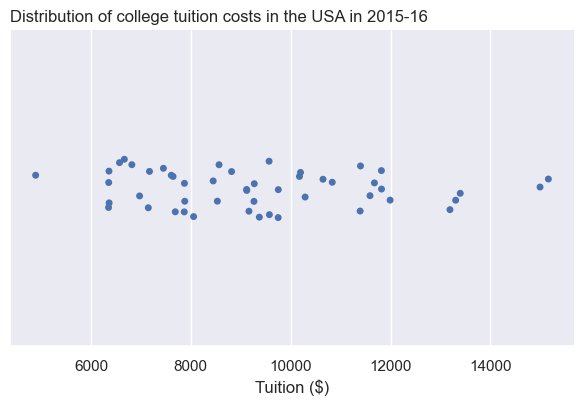

In [10]:
#| code-summary: 'Plot the distribution of college tuition costs in the USA in 2015'
#| code-fold: true
_gq = melted_us_avg_tuition.filter(
    pl.col('year') == '2015-16'
)

_g = sns.catplot(
            data=_gq.collect().to_pandas(),
            x='tuition',
            kind='strip',
            height=4,
            aspect=1.5
)
plt.title(
    'Distribution of college tuition costs in the USA in 2015-16',
    loc='left'
)
plt.xlabel('Tuition ($)')
plt.show()

[^1]: This was used to bring in the state ID, which we needed for mapping the data to a chloropleth map.
[^2]: 2010-11 and 2015-16 in the first, and just 2015-16 in the second.
[^3]: See `'  2007-08 '`
[^4]: Actual column name `'  2007-08 '`

In [11]:
%watermark --iversions

matplotlib: 3.5.3
sys       : 3.10.6 (tags/v3.10.6:9c7b4bd, Aug  1 2022, 21:53:49) [MSC v.1932 64 bit (AMD64)]
pandas    : 1.4.3
seaborn   : 0.11.2
altair    : 4.2.0
polars    : 0.14.5

